In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))
    print(os.path.join(dirname))    

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/timm-0-3-2
/kaggle/input/cassava-leaf-disease-classification
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords
/kaggle/input/cassava-leaf-disease-classification/test_tfrecords
/kaggle/input/cassava-leaf-disease-classification/train_images
/kaggle/input/cassava-leaf-disease-classification/test_images
/kaggle/input/timmefficientnet
/kaggle/input/pretrained-pytorch


In [2]:
#!pip install ../input/timm-0-3-2/timm-0.3.2-py3-none-any.whl

In [3]:
from fastai.vision.all import *

In [4]:
dir_path = '/kaggle/input/cassava-leaf-disease-classification'
path = Path(dir_path)

In [5]:
os.listdir(path)

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

In [6]:
train_path=path/'train_images'

In [7]:
train_path.ls()

(#21397) [Path('/kaggle/input/cassava-leaf-disease-classification/train_images/1235188286.jpg'),Path('/kaggle/input/cassava-leaf-disease-classification/train_images/1215607589.jpg'),Path('/kaggle/input/cassava-leaf-disease-classification/train_images/478554372.jpg'),Path('/kaggle/input/cassava-leaf-disease-classification/train_images/2763304605.jpg'),Path('/kaggle/input/cassava-leaf-disease-classification/train_images/2826122413.jpg'),Path('/kaggle/input/cassava-leaf-disease-classification/train_images/111117998.jpg'),Path('/kaggle/input/cassava-leaf-disease-classification/train_images/231268038.jpg'),Path('/kaggle/input/cassava-leaf-disease-classification/train_images/4201965605.jpg'),Path('/kaggle/input/cassava-leaf-disease-classification/train_images/3224710052.jpg'),Path('/kaggle/input/cassava-leaf-disease-classification/train_images/1290729293.jpg')...]

In [8]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [9]:
train_df['image_id']=train_df['image_id'].apply(lambda x: f'{train_path}/{x}');

In [10]:
train_df.head()

,image_id,label
0,/kaggle/input/cassava-leaf-disease-classification/train_images/1000015157.jpg,0
1,/kaggle/input/cassava-leaf-disease-classification/train_images/1000201771.jpg,3
2,/kaggle/input/cassava-leaf-disease-classification/train_images/100042118.jpg,1
3,/kaggle/input/cassava-leaf-disease-classification/train_images/1000723321.jpg,1
4,/kaggle/input/cassava-leaf-disease-classification/train_images/1000812911.jpg,3


In [11]:
from PIL import Image
im = Image.open(train_df['image_id'][1])
width, height = im.size
print(width,height)

800 600


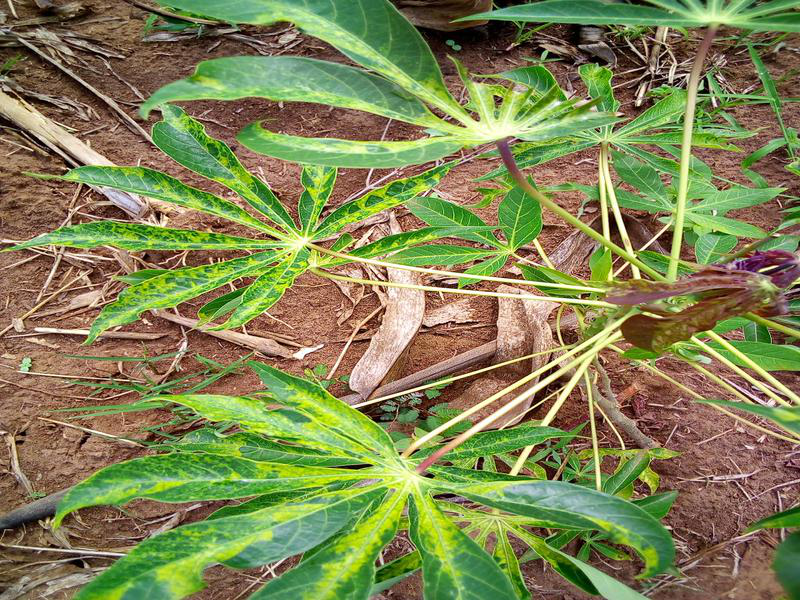

In [12]:
im

### Functions to get the images and targets using dataframe 

In [13]:
def get_y(df):
    return df['label'].item()

def get_x(df):
    return df['image_id']

### Create empty DataBlock

- Once you have DataBlock you  can give it a source 
- Then convert the source to DataSets and DataLoaders by using DataBlock.datasets or DataBlock.dataloaders 

In [14]:
dblock = DataBlock()

In [15]:
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   splitter=RandomSplitter(valid_pct=0.00005),
                   get_x=get_x, 
                   get_y=get_y)
dsets=dblock.datasets(train_df)
dsets.train[0]

(PILImage mode=RGB size=800x600, TensorCategory(3))

In [16]:
dsets.vocab

[0, 1, 2, 3, 4]

### Presizing
#### item_tfms
- Resize to relatively large dimentions, Crop full width or height
#### batch_tfms
- Random crop and augment

In [17]:
tree_tfms = aug_transforms(mult=1.0, do_flip=True, 
                           flip_vert=False, max_rotate=10.0, 
                           min_zoom=1.0, max_zoom=1.1, 
                           max_lighting=0.2, max_warp=0.2, 
                           p_affine=0.75, p_lighting=0.75, 
                           xtra_tfms=None, size=None, 
                           mode='bilinear', pad_mode='reflection',
                           align_corners=True, batch=True, min_scale=1.0)
#tree_tfms = aug_transforms(size=224,max_warp=0)

In [18]:
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   get_x = get_x,
                   get_y= get_y,
                   splitter=RandomSplitter(valid_pct=0.00005),
                   item_tfms = RandomResizedCrop(256),
                   batch_tfms=[*tree_tfms,Normalize.from_stats(*imagenet_stats)])

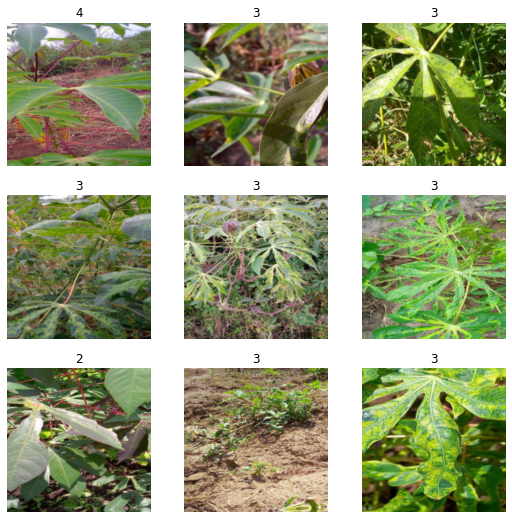

In [19]:
dls = dblock.dataloaders(train_df, bs=32)
dls.show_batch()

In [20]:
# Making pretrained weights work without needing to find the default filename
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
        os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/pretrained-pytorch/resnet50-19c8e357.pth' '/root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth'

In [21]:
from fastai.callback.fp16 import *

from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50,metrics=accuracy,
                    normalize=True,pretrained=True, 
                    model_dir='/kaggle/working/models',
                    cbs=MixUp(alpha = 0.3)).to_native_fp16()

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.0010000000474974513)

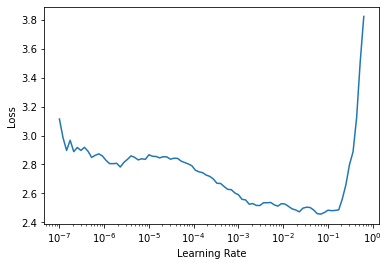

In [22]:
learn.lr_find()

In [23]:
learn.fine_tune(10, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,time
0,1.255549,0.008942,1.000000,04:41
1,0.913572,0.065684,1.000000,04:17
2,0.845820,0.248076,1.000000,04:18


epoch,train_loss,valid_loss,accuracy,time
0,0.730059,0.045559,1.000000,04:38
1,0.715462,0.069237,1.000000,04:39
2,0.690517,0.042064,1.000000,04:37
3,0.722933,0.038798,1.000000,04:34
4,0.677015,0.115411,1.000000,04:38
5,0.667725,0.054531,1.000000,04:37
6,0.638843,0.020007,1.000000,04:37
7,0.612043,0.051456,1.000000,04:38
8,0.599145,0.027622,1.000000,04:35
9,0.575762,0.042783,1.000000,04:36


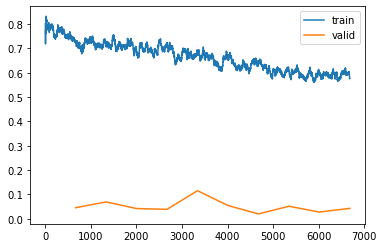

In [24]:
learn.recorder.plot_loss()

In [25]:
learn = learn.to_native_fp32()

In [26]:
learn.export()

In [27]:
learn.save('model-2')

Path('/kaggle/working/models/model-2.pth')

In [28]:
sample_df = pd.read_csv(path/'sample_submission.csv')
sample_df.head()

,image_id,label
0,2216849948.jpg,4


In [29]:
sample_copy = sample_df.copy()
test_path=path/'test_images'
sample_copy['image_id'] = sample_copy['image_id'].apply(lambda x: f'{test_path}/{x}')
sample_copy

,image_id,label
0,/kaggle/input/cassava-leaf-disease-classification/test_images/2216849948.jpg,4


In [30]:
test_dl = learn.dls.test_dl(sample_copy)

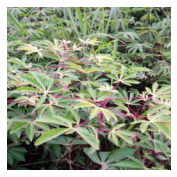

In [31]:
test_dl.show_batch()

In [32]:
preds, _ = learn.tta(dl=test_dl, n=16, beta=0)

In [33]:
sample_df['label'] = preds.argmax(dim=-1).numpy()

In [34]:
sample_df.to_csv('/kaggle/working/submission.csv',index=False)